# Table Tutorial

## Preprocessing

In [ ]:
import os
os.remove('snorkel.db')

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parse the `Corpus`

In [ ]:
from snorkel.parser import CorpusParser
from snorkel.parser import HTMLParser
from snorkel.parser import OmniParser

doc_parser = HTMLParser(path='data/hardware/hardware_html/')
context_parser = OmniParser()
cp = CorpusParser(doc_parser, context_parser, max_docs=101)

In [ ]:
%time corpus = cp.parse_corpus(name='Hardware', session=session)

In [ ]:
for doc in corpus.documents[:5]: print doc

### Saving the `Corpus`
Finally, we persist the parsed corpus in Snorkel's database backend:

In [ ]:
session.add(corpus)
session.commit()

### Reloading the `Corpus`
If the corpus has already been parsed, load it here:

In [2]:
from snorkel.models import Corpus

corpus = session.query(Corpus).filter(Corpus.name == 'Hardware').one()
print corpus
print "%s contains %d Documents" % (corpus.name, len(corpus))

Corpus (Hardware)
Hardware contains 100 Documents


### Split the `Corpus` into Train/Dev/Test

In [3]:
# If necessary:
train = session.query(Corpus).filter(Corpus.name == 'Hardware Training').one()
session.delete(train)
dev = session.query(Corpus).filter(Corpus.name == 'Hardware Development').one()
session.delete(dev)
test = session.query(Corpus).filter(Corpus.name == 'Hardware Test').one()
session.delete(test)
session.commit()

In [4]:
from snorkel.utils import split_corpus

split_corpus(session, corpus, train=0.50, development=0.25, test=0.25, seed=3)

50 Documents added to corpus Hardware Training
25 Documents added to corpus Hardware Development
25 Documents added to corpus Hardware Test


## Extract the `Candidates`

In [5]:
from snorkel.models import candidate_subclass

Part_Temp = candidate_subclass('Part_Temp', ['part','temp'])

In [6]:
from snorkel.candidates import OmniNgrams

omni_ngrams = OmniNgrams(n_max=3, split_tokens=None)

In [7]:
from hardware_utils import load_extended_parts_dict

filename='data/hardware/hardware_gold.csv'
parts_dict = load_extended_parts_dict(filename)
print "Loaded %d part numbers." % len(parts_dict)

Loaded 5331 part numbers.


In [8]:
from snorkel.matchers import DictionaryMatch, RegexMatchSpan

parts_matcher = DictionaryMatch(d=parts_dict, ignore_case=True)
temp_matcher = RegexMatchSpan(rgx=ur'-\s?[5-7][05]')

In [9]:
from snorkel.candidates import CandidateExtractor

ce = CandidateExtractor(Part_Temp, [omni_ngrams, omni_ngrams], [parts_matcher, temp_matcher])

In [10]:
%time candidates = ce.extract(corpus.documents, 'Hardware Training Candidates', session)
print "%s contains %d Candidates" % (candidates, len(candidates))

[========================================] 100%

CPU times: user 29.5 s, sys: 1.44 s, total: 31 s
Wall time: 31.5 s
Candidate Set (Hardware Training Candidates) contains 646 Candidates


In [ ]:
# session.rollback()
# session.delete(c)
# session.commit()

In [11]:
for c in candidates[:5]:
    print c

Part_Temp(Span("BC807-25", parent=80944, chars=[36,43], words=[5,5]), Span("-50", parent=123581, chars=[0,2], words=[0,0]))
Part_Temp(Span("BC807-25", parent=80944, chars=[36,43], words=[5,5]), Span("-50", parent=123653, chars=[2,4], words=[1,1]))
Part_Temp(Span("BC817", parent=80853, chars=[33,37], words=[5,5]), Span("-50", parent=123581, chars=[0,2], words=[0,0]))
Part_Temp(Span("BC817", parent=80853, chars=[33,37], words=[5,5]), Span("-50", parent=123653, chars=[2,4], words=[1,1]))
Part_Temp(Span("BC818-16", parent=9751, chars=[22,29], words=[3,3]), Span("- 65", parent=128693, chars=[0,3], words=[0,1]))


### Saving the extracted candidates

In [12]:
session.add(candidates)
session.commit()

### Reloading the candidates

In [13]:
from snorkel.models import CandidateSet

candidates = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()
print "%s contains %d Candidates" % (candidates, len(candidates))

Candidate Set (Hardware Training Candidates) contains 646 Candidates


### Repeating for development and test corpora

In [14]:
for corpus_name in ['Hardware Development', 'Hardware Test']:
    corpus = session.query(Corpus).filter(Corpus.name == corpus_name).one()
    %time c = ce.extract(corpus.documents, corpus_name + ' Candidates', session)
    session.add(c)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

[========================================] 100%

CPU times: user 7.38 s, sys: 240 ms, total: 7.62 s
Wall time: 7.73 s
Candidate Set (Hardware Training Candidates) contains 646 Candidates
[========================================] 100%

CPU times: user 5.65 s, sys: 150 ms, total: 5.81 s
Wall time: 5.82 s
Candidate Set (Hardware Training Candidates) contains 646 Candidates


## Prepare Gold Data

In [ ]:
# Make labels gold, candidates gold

In [ ]:
# TEMP
import os
os.remove('snorkel.db')
os.system('cp snorkel.db\ candidates snorkel.db')
from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import Corpus
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Training').one()
print "%s contains %d Documents" % (corpus, len(corpus))
from snorkel.models import candidate_subclass
Part_Temp = candidate_subclass('Part_Temp', ['part','temp'])
from snorkel.models import CandidateSet
candidates = session.query(CandidateSet).filter(CandidateSet.name == 'Hardware Training Candidates').one()
print "%s contains %d Candidates" % (candidates, len(candidates))

In [15]:
from snorkel.loaders import ExternalAnnotationsLoader

loader = ExternalAnnotationsLoader(session, Part_Temp, 
                                   'Hardware Training Candidates -- Gold',
                                   'Hardware Training Labels -- Gold',
                                   expand_candidate_set=True)

In [16]:
import os
from hardware_utils import load_hardware_labels

filename = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
load_hardware_labels(loader, candidates, filename, 'Part_Temp', attrib='stg_temp_min')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


In [17]:
from snorkel.models import Label

train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()
print "%d/%d Candidates have positive Labels" % (len(train_gold), len(train))
print "%d Labels loaded" % session.query(Label).filter(
    Label.key == loader.annotation_key).count()

154/646 Candidates have positive Labels
154 Labels loaded


In [18]:
for set_name in ['Development', 'Test']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    loader = ExternalAnnotationsLoader(session, Part_Temp, 
                                       'Hardware %s Candidates -- Gold' % set_name,
                                       'Hardware %s Labels -- Gold' % set_name,
                                       expand_candidate_set=True)
    load_hardware_labels(loader, candidates, filename, 'Part_Temp', attrib='stg_temp_min')
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates have positive Labels" % (len(candidates_gold), len(candidates))
    print "%d Labels loaded" % session.query(Label).filter(
        Label.key == loader.annotation_key).count()

44/116 Candidates have positive Labels
44 Labels loaded
31/91 Candidates have positive Labels
31 Labels loaded


## Generating Features

In [19]:
from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(CandidateSet.name == 'Hardware Training Candidates').one()

In [20]:
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()

### Creating feature matrix

In [21]:
%time F_train = feature_manager.create(session, train, 'Train Features')

[========================================] 97%

Loading sparse Feature matrix...
CPU times: user 21.8 s, sys: 536 ms, total: 22.4 s
Wall time: 22.2 s


### Reloading feature matrix

In [22]:
%time F_train = feature_manager.load(session, train, 'Train Features')

CPU times: user 142 ms, sys: 2.12 ms, total: 144 ms
Wall time: 155 ms


In [23]:
F_train

<646x1714 sparse matrix of type '<type 'numpy.float64'>'
	with 10918 stored elements in Compressed Sparse Row format>

In [24]:
F_train.get_candidate(0)

Part_Temp(Span("BC807-25", parent=80944, chars=[36,43], words=[5,5]), Span("-50", parent=123581, chars=[0,2], words=[0,0]))

In [25]:
F_train.get_key(0)

AnnotationKey (TDL_INV_LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[None])

In [26]:
from snorkel.utils import get_keys_by_candidate

for f in get_keys_by_candidate(F_train, F_train.get_candidate(0))[:10]: print f

AnnotationKey (TDL_INV_LEMMA:PARENTS-OF-BETWEEN-MENTION-and-MENTION[None])
AnnotationKey (TDL_INV_LEMMA:BETWEEN-MENTION-and-MENTION[bc807-25])
AnnotationKey (TDL_INV_DEP_LABEL:BETWEEN-MENTION-and-MENTION[ROOT])
AnnotationKey (TDL_INV_DEP_LABEL|LEMMA:BETWEEN-MENTION-and-MENTION[ROOT|bc807-25])
AnnotationKey (TDL_INV_LEMMA:SEQ-BETWEEN[and])
AnnotationKey (TDL_INV_LEMMA:SEQ-BETWEEN[characteristic])
AnnotationKey (TDL_INV_LEMMA:SEQ-BETWEEN[curve])
AnnotationKey (TDL_INV_LEMMA:SEQ-BETWEEN[(])
AnnotationKey (TDL_INV_LEMMA:SEQ-BETWEEN[and characteristic])
AnnotationKey (TDL_INV_LEMMA:SEQ-BETWEEN[characteristic curve])


## Applying LFs

In [27]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

In [ ]:
# TEMP
# from snorkel import SnorkelSession
# session = SnorkelSession()
# from snorkel.models import candidate_subclass
# Part_Temp = candidate_subclass('Part_Temp', ['part','temp'])
# from snorkel.models import CandidateSet
# candidates = session.query(CandidateSet).filter(CandidateSet.name == 'Hardware Training Candidates').one()
# print candidates
# train = candidates

In [28]:
from snorkel.lf_helpers import get_right_ngrams, get_left_ngrams, contains_token
from snorkel.lf_helpers import get_phrase_ngrams, get_cell_ngrams, get_neighbor_cell_ngrams
from snorkel.lf_helpers import get_row_ngrams, get_col_ngrams, get_aligned_ngrams
cand = train[0]
print cand
print cand[1].parent.cell.text
print get_left_ngrams(cand[1])
print get_right_ngrams(cand[1])
print get_phrase_ngrams(cand[1])
print get_cell_ngrams(cand[1])
print get_neighbor_cell_ngrams(cand[1])
print get_row_ngrams(cand[1])
print get_col_ngrams(cand[1])
print get_aligned_ngrams(cand[1])

Part_Temp(Span("BC807-25", parent=80944, chars=[36,43], words=[5,5]), Span("-50", parent=123581, chars=[0,2], words=[0,0]))
-50
[]
[]
[]
[u'-50']
[u'min', u'v', u'cbo', u'-', u'-45']
[u'collector-base', u'breakdown', u'voltage', '(', u'i', u'c', u'=', u'-10', u'?', u'a', u',', u'i', u'e', u'=', u'0', ')', u'v', u'cbo', u'-', u'v']
[u'min', u'-45', u'-5', u'-', u'-', u'-', u'160', u'-', u'-', u'100']
[u'collector-base', u'breakdown', u'voltage', '(', u'i', u'c', u'=', u'-10', u'?', u'a', u',', u'i', u'e', u'=', u'0', ')', u'v', u'cbo', u'-', u'v', u'min', u'-45', u'-5', u'-', u'-', u'-', u'160', u'-', u'-', u'100']


In [29]:
from snorkel.lf_helpers import *

LFs = []

def LF_to_range(c):
    return 1 if 'to' in get_right_ngrams(c) else 0
LFs.append(LF_to_range)

def LF_tilde_range(c):
    return 1 if '~' in get_right_ngrams(c) else 0
LFs.append(LF_tilde_range)

def LF_through_range(c):
    return 1 if set(['through','thru']).intersection(set(get_right_ngrams(c))) > 0 else 0
LFs.append(LF_through_range)

def LF_contains_minus(c):
    return 1 if contains_token(c, '-') or contains_token(c,'-50') else -1
LFs.append(LF_contains_minus)

def LF_storage(c):
    return 1 if 'storage' in get_row_ngrams(c, attrib='words') else -1
LFs.append(LF_storage)

def LF_tstg(c):
    return 1 if 'tstg' in get_row_ngrams(c, attrib='words') else -1
LFs.append(LF_tstg)

def LF_tj(c):
    return 1 if 'tj' in get_row_ngrams(c, attrib='words') else -1
LFs.append(LF_tj)

def LF_temperature(c):
    return 1 if 'temperature' in get_row_ngrams(c, attrib='words') else -1
LFs.append(LF_temperature)

def LF_celsius(c):
    return 1 if 'c' in get_row_ngrams(c, attrib='words') else -1
LFs.append(LF_celsius)

def LF_max(c):
    return 1 if 'max' in get_aligned_ngrams(c, attrib='words') else 0
LFs.append(LF_max)

def LF_min(c):
    return 1 if 'min' in get_aligned_ngrams(c, attrib='words') else 0
LFs.append(LF_min)

In [30]:
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 97%

Loading sparse Label matrix...
CPU times: user 11 s, sys: 485 ms, total: 11.5 s
Wall time: 11.3 s


<646x11 sparse matrix of type '<type 'numpy.float64'>'
	with 4603 stored elements in Compressed Sparse Row format>

In [31]:
L_train.lf_stats()

,conflicts,coverage,j,overlaps
LF_to_range,0.236842,0.236842,0,0.236842
LF_tilde_range,0.040248,0.040248,1,0.040248
LF_through_range,0.978328,0.978328,2,0.978328
LF_contains_minus,0.978328,0.978328,3,0.978328
LF_storage,0.978328,0.978328,4,0.978328
LF_tstg,0.978328,0.978328,5,0.978328
LF_tj,0.978328,0.978328,6,0.978328
LF_temperature,0.978328,0.978328,7,0.978328
LF_celsius,0.978328,0.978328,8,0.978328
LF_max,0.000000,0.000000,9,0.000000


## Train Generative Model

In [32]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=3000, rate=1e-5)

/Users/bradenhancock/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	646
Features:			11
Begin training for rate=1e-05, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.913727
	Learning epoch = 250	Gradient mag. = 0.963354
	Learning epoch = 500	Gradient mag. = 0.964895
	Learning epoch = 750	Gradient mag. = 0.966439
	Learning epoch = 1000	Gradient mag. = 0.967987
	Learning epoch = 1250	Gradient mag. = 0.969537
	Learning epoch = 1500	Gradient mag. = 0.971091
	Learning epoch = 1750	Gradient mag. = 0.972648
	Learning epoch = 2000	Gradient mag. = 0.974208
	Learning epoch = 2250	Gradient mag. = 0.975771
	Learning epoch = 2500	Gradient mag. = 0.977337
	Learning epoch = 2750	Gradient mag. = 0.978907
Final gradient magnitude for rate=1e-05, mu=1e-06: 0.980


In [33]:
gen_model.save(session, 'Generative Params')

In [34]:
train_marginals = gen_model.marginals(L_train)

## Train Discriminative Model

In [35]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=5000, rate=1e-3)

Training marginals (!= 0.5):	632
Features:			1714
Using gradient descent...
	Learning epoch = 0	Step size = 0.001
	Loss = 438.069018	Gradient magnitude = 441.369984
	Learning epoch = 100	Step size = 0.000904792147114
	Loss = 114.074824	Gradient magnitude = 9.462703
	Learning epoch = 200	Step size = 0.000818648829479
	Loss = 109.571442	Gradient magnitude = 5.597344
	Learning epoch = 300	Step size = 0.000740707032156
	Loss = 107.721648	Gradient magnitude = 4.271160
	Learning epoch = 400	Step size = 0.000670185906007
	Loss = 106.637602	Gradient magnitude = 3.614356
	Learning epoch = 500	Step size = 0.000606378944861
	Loss = 105.896542	Gradient magnitude = 3.221343
	Learning epoch = 600	Step size = 0.000548646907485
	Loss = 105.347617	Gradient magnitude = 2.956399
	Learning epoch = 700	Step size = 0.000496411413431
	Loss = 104.921375	Gradient magnitude = 2.763498
	Learning epoch = 800	Step size = 0.00044914914861
	Loss = 104.580079	Gradient magnitude = 2.615856
	Learning epoch = 900	Step s

In [36]:
disc_model.w.shape

(1714,)

In [37]:
%time disc_model.save(session, "Discriminative Params")

CPU times: user 476 ms, sys: 26.7 ms, total: 503 ms
Wall time: 492 ms


## Assess Performance on Dev Set

In [38]:
from snorkel.models import CandidateSet
dev = session.query(CandidateSet).filter(CandidateSet.name == 'Hardware Development Candidates').one()

In [39]:
%time F_dev = feature_manager.update(session, dev, 'Train Features', False)

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 3.66 s, sys: 129 ms, total: 3.79 s
Wall time: 3.79 s


In [40]:
L_dev = label_manager.load(session, dev, "Hardware Development Labels -- Gold")

In [41]:
gold_dev_set = session.query(CandidateSet).filter(CandidateSet.name == 'Hardware Development Candidates').one()

In [42]:
F_dev.shape

(116, 1714)

Calibration plot:


/Users/bradenhancock/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


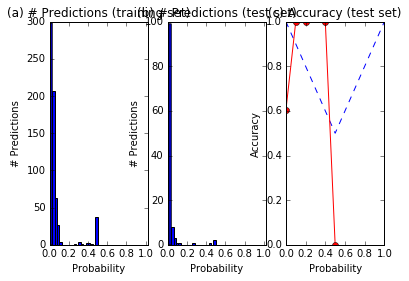

Test set size:	116
----------------------------------------
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
----------------------------------------
Precision:	nan
Recall:		0.0
F1 Score:	nan
----------------------------------------
TP: 0 | FP: 0 | TN: 72 | FN: 44
Recall-corrected Noise-aware Model
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Corpus Precision nan
Corpus Recall    0.0
Corpus F1        nan
----------------------------------------
TP: 0 | FP: 0 | TN: 72 | FN: 44



In [43]:
tp, fp, tn, fn = disc_model.score(F_dev, L_dev, gold_dev_set)